# Autoencoder para MNIST con Gradient Accumulation

## Descripción del Proyecto

Este notebook implementa un Autoencoder neuronal para el dataset MNIST utilizando PyTorch. La implementación incluye:

1. **Arquitectura de Autoencoder**: Red neuronal con encoder y decoder para reconstrucción de imágenes
2. **Gradient Accumulation**: Técnica para simular batch sizes más grandes sin incrementar el uso de memoria
3. **Training Loop Completo**: Implementación profesional con métricas, logging y validación

## Objetivos

- Construir una arquitectura de Autoencoder eficiente para MNIST
- Implementar Gradient Accumulation para optimizar el entrenamiento
- Evaluar la calidad de reconstrucción de las imágenes

In [9]:
# Importación de librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from typing import Tuple, Dict, List
import time

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizando dispositivo: {device}")

# Configuración para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Utilizando dispositivo: cpu


In [10]:
# Configuración e Hiperparámetros
class Config:
    """Clase para centralizar la configuración del modelo"""
    
    # Hiperparámetros del dataset
    BATCH_SIZE = 128
    NUM_WORKERS = 4
    
    # Hiperparámetros del modelo
    INPUT_DIM = 28 * 28  # Dimensión de entrada (784 para MNIST)
    HIDDEN_DIMS = [512, 256, 128, 64]  # Dimensiones de las capas ocultas
    LATENT_DIM = 32  # Dimensión del espacio latente
    
    # Hiperparámetros de entrenamiento
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 50
    WEIGHT_DECAY = 1e-5
    
    # Gradient Accumulation
    ACCUMULATION_STEPS = 4  # Acumular gradientes por 4 steps
    EFFECTIVE_BATCH_SIZE = BATCH_SIZE * ACCUMULATION_STEPS  # Batch size efectivo
    
    # Logging y guardado
    LOG_INTERVAL = 100  # Cada cuántos batches loggear
    SAVE_INTERVAL = 10  # Cada cuántas épocas guardar el modelo
    
    # Directorio para guardar resultados
    SAVE_DIR = "autoencoder_results"

config = Config()

# Crear directorio para resultados
os.makedirs(config.SAVE_DIR, exist_ok=True)

print("Configuración del modelo:")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Batch size efectivo (con accumulation): {config.EFFECTIVE_BATCH_SIZE}")
print(f"- Accumulation steps: {config.ACCUMULATION_STEPS}")
print(f"- Dimensión latente: {config.LATENT_DIM}")
print(f"- Learning rate: {config.LEARNING_RATE}")
print(f"- Épocas: {config.NUM_EPOCHS}")

Configuración del modelo:
- Batch size: 128
- Batch size efectivo (con accumulation): 512
- Accumulation steps: 4
- Dimensión latente: 32
- Learning rate: 0.001
- Épocas: 50


Cargando dataset MNIST...
Dataset cargado exitosamente:
- Batches de entrenamiento: 469
- Batches de validación: 79
- Tamaño total entrenamiento: 60000
- Tamaño total validación: 10000
Dataset cargado exitosamente:
- Batches de entrenamiento: 469
- Batches de validación: 79
- Tamaño total entrenamiento: 60000
- Tamaño total validación: 10000


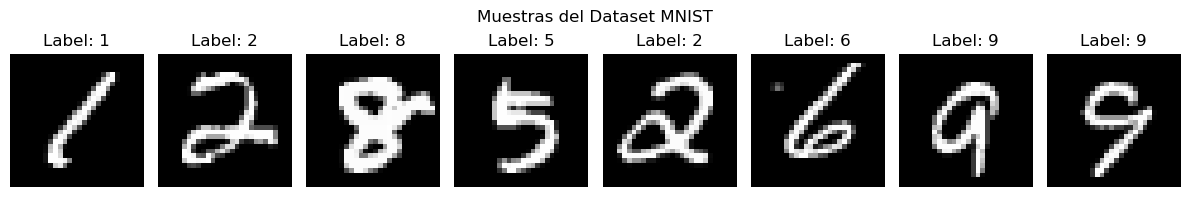

In [11]:
# Carga y Preprocesamiento del Dataset MNIST

def get_mnist_dataloaders(batch_size: int = 128, num_workers: int = 4) -> Tuple[DataLoader, DataLoader]:
    """
    Carga el dataset MNIST y retorna los dataloaders para entrenamiento y validación.
    
    Args:
        batch_size: Tamaño del batch
        num_workers: Número de workers para el DataLoader
        
    Returns:
        Tuple con dataloaders de entrenamiento y validación
    """
    
    # Transformaciones para normalizar las imágenes
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Media y std de MNIST
    ])
    
    # Cargar datasets
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    # Crear dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, test_loader

# Cargar los datos
print("Cargando dataset MNIST...")
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=config.BATCH_SIZE, 
    num_workers=config.NUM_WORKERS
)

print(f"Dataset cargado exitosamente:")
print(f"- Batches de entrenamiento: {len(train_loader)}")
print(f"- Batches de validación: {len(test_loader)}")
print(f"- Tamaño total entrenamiento: {len(train_loader.dataset)}")
print(f"- Tamaño total validación: {len(test_loader.dataset)}")

# Visualizar algunas muestras
def visualize_samples(dataloader: DataLoader, num_samples: int = 8):
    """Visualiza muestras del dataset"""
    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.suptitle('Muestras del Dataset MNIST')
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

In [12]:
# Arquitectura del Autoencoder

class Encoder(nn.Module):
    """
    Encoder del Autoencoder.
    Comprime la entrada de alta dimensión a un espacio latente de menor dimensión.
    """
    
    def __init__(self, input_dim: int, hidden_dims: List[int], latent_dim: int):
        """
        Args:
            input_dim: Dimensión de entrada (784 para MNIST)
            hidden_dims: Lista con las dimensiones de las capas ocultas
            latent_dim: Dimensión del espacio latente
        """
        super(Encoder, self).__init__()
        
        # Construir las capas del encoder
        layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim
        
        # Capa final hacia el espacio latente
        layers.append(nn.Linear(current_dim, latent_dim))
        
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass del encoder
        
        Args:
            x: Tensor de entrada de forma (batch_size, input_dim)
            
        Returns:
            Representación en el espacio latente
        """
        return self.encoder(x)


class Decoder(nn.Module):
    """
    Decoder del Autoencoder.
    Reconstruye la entrada original desde el espacio latente.
    """
    
    def __init__(self, latent_dim: int, hidden_dims: List[int], output_dim: int):
        """
        Args:
            latent_dim: Dimensión del espacio latente
            hidden_dims: Lista con las dimensiones de las capas ocultas (en orden inverso)
            output_dim: Dimensión de salida (784 para MNIST)
        """
        super(Decoder, self).__init__()
        
        # Construir las capas del decoder (orden inverso)
        layers = []
        current_dim = latent_dim
        
        # Invertir el orden de las dimensiones ocultas
        reversed_hidden_dims = hidden_dims[::-1]
        
        for hidden_dim in reversed_hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim
        
        # Capa final hacia la salida
        layers.extend([
            nn.Linear(current_dim, output_dim),
            nn.Tanh()  # Tanh para que la salida esté en [-1, 1]
        ])
        
        self.decoder = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass del decoder
        
        Args:
            x: Tensor del espacio latente de forma (batch_size, latent_dim)
            
        Returns:
            Reconstrucción de la entrada original
        """
        return self.decoder(x)


class Autoencoder(nn.Module):
    """
    Autoencoder completo que combina encoder y decoder.
    """
    
    def __init__(self, input_dim: int, hidden_dims: List[int], latent_dim: int):
        """
        Args:
            input_dim: Dimensión de entrada
            hidden_dims: Dimensiones de las capas ocultas
            latent_dim: Dimensión del espacio latente
        """
        super(Autoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dims, input_dim)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass completo del autoencoder
        
        Args:
            x: Tensor de entrada
            
        Returns:
            Tuple con (reconstrucción, representación_latente)
        """
        # Aplanar la entrada si es necesario
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Encoding
        latent = self.encoder(x)
        
        # Decoding
        reconstruction = self.decoder(latent)
        
        return reconstruction, latent
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Codificar entrada al espacio latente"""
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        return self.encoder(x)
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decodificar desde el espacio latente"""
        return self.decoder(z)


# Crear el modelo
model = Autoencoder(
    input_dim=config.INPUT_DIM,
    hidden_dims=config.HIDDEN_DIMS,
    latent_dim=config.LATENT_DIM
).to(device)

# Mostrar información del modelo
def count_parameters(model):
    """Cuenta el número de parámetros entrenables"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Arquitectura del Autoencoder:")
print(model)
print(f"\nNúmero total de parámetros: {count_parameters(model):,}")

# Mostrar el flujo de información
print(f"\nFlujo de información:")
print(f"Entrada: {config.INPUT_DIM} -> ", end="")
for dim in config.HIDDEN_DIMS:
    print(f"{dim} -> ", end="")
print(f"{config.LATENT_DIM} (latente)")
print(f"Latente: {config.LATENT_DIM} -> ", end="")
for dim in reversed(config.HIDDEN_DIMS):
    print(f"{dim} -> ", end="")
print(f"{config.INPUT_DIM} (reconstrucción)")

Arquitectura del Autoencoder:
Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=128, out_features=64, bias=True)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU(inplace=True)
      (15): Dropout(p=0.2, inplace=Fal

In [13]:
# Función de Pérdida y Métricas

class AutoencoderLoss(nn.Module):
    """
    Función de pérdida personalizada para el autoencoder.
    Combina MSE Loss y regularización.
    """
    
    def __init__(self, reconstruction_weight: float = 1.0, regularization_weight: float = 1e-5):
        """
        Args:
            reconstruction_weight: Peso para la pérdida de reconstrucción
            regularization_weight: Peso para la regularización
        """
        super(AutoencoderLoss, self).__init__()
        self.reconstruction_weight = reconstruction_weight
        self.regularization_weight = regularization_weight
        self.mse_loss = nn.MSELoss()
        
    def forward(self, reconstruction: torch.Tensor, target: torch.Tensor, 
                latent: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Calcula la pérdida total del autoencoder
        
        Args:
            reconstruction: Reconstrucción del autoencoder
            target: Objetivo (entrada original)
            latent: Representación latente
            
        Returns:
            Diccionario con las pérdidas
        """
        # Pérdida de reconstrucción (MSE)
        reconstruction_loss = self.mse_loss(reconstruction, target.view(target.size(0), -1))
        
        # Regularización L2 del espacio latente
        latent_regularization = torch.mean(torch.sum(latent ** 2, dim=1))
        
        # Pérdida total
        total_loss = (self.reconstruction_weight * reconstruction_loss + 
                     self.regularization_weight * latent_regularization)
        
        return {
            'total_loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'latent_regularization': latent_regularization
        }


def calculate_metrics(reconstruction: torch.Tensor, target: torch.Tensor) -> Dict[str, float]:
    """
    Calcula métricas adicionales para evaluar la calidad de reconstrucción
    
    Args:
        reconstruction: Reconstrucción del autoencoder
        target: Objetivo (entrada original)
        
    Returns:
        Diccionario con métricas
    """
    with torch.no_grad():
        # Aplanar tensores
        recon_flat = reconstruction.view(reconstruction.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        
        # MSE
        mse = F.mse_loss(recon_flat, target_flat).item()
        
        # MAE (Mean Absolute Error)
        mae = F.l1_loss(recon_flat, target_flat).item()
        
        # PSNR (Peak Signal-to-Noise Ratio)
        psnr = 20 * torch.log10(torch.tensor(1.0) / torch.sqrt(torch.tensor(mse)))
        
        # Correlación promedio
        correlation = 0.0
        for i in range(recon_flat.size(0)):
            corr = torch.corrcoef(torch.stack([recon_flat[i], target_flat[i]]))[0, 1]
            if not torch.isnan(corr):
                correlation += corr.item()
        correlation /= recon_flat.size(0)
        
        return {
            'mse': mse,
            'mae': mae,
            'psnr': psnr.item(),
            'correlation': correlation
        }


# Inicializar función de pérdida y optimizador
criterion = AutoencoderLoss(
    reconstruction_weight=1.0,
    regularization_weight=config.WEIGHT_DECAY
)

optimizer = optim.Adam(
    model.parameters(), 
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Scheduler para learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

print("Componentes de entrenamiento inicializados:")
print(f"- Función de pérdida: AutoencoderLoss")
print(f"- Optimizador: Adam (lr={config.LEARNING_RATE})")
print(f"- Scheduler: ReduceLROnPlateau")
print(f"- Peso de reconstrucción: {criterion.reconstruction_weight}")
print(f"- Peso de regularización: {criterion.regularization_weight}")

Componentes de entrenamiento inicializados:
- Función de pérdida: AutoencoderLoss
- Optimizador: Adam (lr=0.001)
- Scheduler: ReduceLROnPlateau
- Peso de reconstrucción: 1.0
- Peso de regularización: 1e-05


In [14]:
# Training Loop con Gradient Accumulation

class TrainingLogger:
    """Clase para manejar el logging durante el entrenamiento"""
    
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []
        self.learning_rates = []
        
    def log_epoch(self, epoch: int, train_loss: float, val_loss: float, 
                  train_metrics: Dict, val_metrics: Dict, lr: float):
        """Registra métricas de una época"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_metrics.append(train_metrics)
        self.val_metrics.append(val_metrics)
        self.learning_rates.append(lr)
        
    def plot_training_history(self):
        """Grafica el historial de entrenamiento"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        epochs = range(1, len(self.train_losses) + 1)
        
        # Loss
        axes[0, 0].plot(epochs, self.train_losses, 'b-', label='Train')
        axes[0, 0].plot(epochs, self.val_losses, 'r-', label='Validation')
        axes[0, 0].set_title('Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # MSE
        train_mse = [m['mse'] for m in self.train_metrics]
        val_mse = [m['mse'] for m in self.val_metrics]
        axes[0, 1].plot(epochs, train_mse, 'b-', label='Train')
        axes[0, 1].plot(epochs, val_mse, 'r-', label='Validation')
        axes[0, 1].set_title('MSE')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MSE')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # PSNR
        train_psnr = [m['psnr'] for m in self.train_metrics]
        val_psnr = [m['psnr'] for m in self.val_metrics]
        axes[0, 2].plot(epochs, train_psnr, 'b-', label='Train')
        axes[0, 2].plot(epochs, val_psnr, 'r-', label='Validation')
        axes[0, 2].set_title('PSNR')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('PSNR (dB)')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # MAE
        train_mae = [m['mae'] for m in self.train_metrics]
        val_mae = [m['mae'] for m in self.val_metrics]
        axes[1, 0].plot(epochs, train_mae, 'b-', label='Train')
        axes[1, 0].plot(epochs, val_mae, 'r-', label='Validation')
        axes[1, 0].set_title('MAE')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('MAE')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Correlation
        train_corr = [m['correlation'] for m in self.train_metrics]
        val_corr = [m['correlation'] for m in self.val_metrics]
        axes[1, 1].plot(epochs, train_corr, 'b-', label='Train')
        axes[1, 1].plot(epochs, val_corr, 'r-', label='Validation')
        axes[1, 1].set_title('Correlation')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Correlation')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        # Learning Rate
        axes[1, 2].plot(epochs, self.learning_rates, 'g-')
        axes[1, 2].set_title('Learning Rate')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_yscale('log')
        axes[1, 2].grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.SAVE_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()


def train_epoch_with_accumulation(model: nn.Module, train_loader: DataLoader, 
                                criterion: nn.Module, optimizer: optim.Optimizer,
                                accumulation_steps: int, device: torch.device) -> Tuple[float, Dict]:
    """
    Entrena una época con gradient accumulation
    
    Args:
        model: Modelo a entrenar
        train_loader: DataLoader de entrenamiento
        criterion: Función de pérdida
        optimizer: Optimizador
        accumulation_steps: Número de steps para acumular gradientes
        device: Dispositivo de cómputo
        
    Returns:
        Tuple con (pérdida_promedio, métricas_promedio)
    """
    model.train()
    
    total_loss = 0.0
    total_metrics = {'mse': 0.0, 'mae': 0.0, 'psnr': 0.0, 'correlation': 0.0}
    num_batches = 0
    
    # Inicializar gradientes
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, _) in enumerate(progress_bar):
        data = data.to(device)
        
        # Forward pass
        reconstruction, latent = model(data)
        
        # Calcular pérdida
        loss_dict = criterion(reconstruction, data, latent)
        loss = loss_dict['total_loss']
        
        # Escalar la pérdida por accumulation steps
        loss = loss / accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Actualizar cada accumulation_steps o en el último batch
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Actualizar parámetros
            optimizer.step()
            optimizer.zero_grad()
        
        # Acumular métricas
        total_loss += loss.item() * accumulation_steps  # Reescalar para métricas
        
        # Calcular métricas adicionales
        metrics = calculate_metrics(reconstruction, data)
        for key, value in metrics.items():
            total_metrics[key] += value
        
        num_batches += 1
        
        # Actualizar progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item() * accumulation_steps:.4f}',
            'MSE': f'{metrics["mse"]:.4f}',
            'PSNR': f'{metrics["psnr"]:.2f}dB'
        })
    
    # Promediar métricas
    avg_loss = total_loss / num_batches
    avg_metrics = {key: value / num_batches for key, value in total_metrics.items()}
    
    return avg_loss, avg_metrics


def validate_epoch(model: nn.Module, val_loader: DataLoader, 
                  criterion: nn.Module, device: torch.device) -> Tuple[float, Dict]:
    """
    Valida una época
    
    Args:
        model: Modelo a validar
        val_loader: DataLoader de validación
        criterion: Función de pérdida
        device: Dispositivo de cómputo
        
    Returns:
        Tuple con (pérdida_promedio, métricas_promedio)
    """
    model.eval()
    
    total_loss = 0.0
    total_metrics = {'mse': 0.0, 'mae': 0.0, 'psnr': 0.0, 'correlation': 0.0}
    num_batches = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")
        
        for data, _ in progress_bar:
            data = data.to(device)
            
            # Forward pass
            reconstruction, latent = model(data)
            
            # Calcular pérdida
            loss_dict = criterion(reconstruction, data, latent)
            loss = loss_dict['total_loss']
            
            # Acumular métricas
            total_loss += loss.item()
            
            # Calcular métricas adicionales
            metrics = calculate_metrics(reconstruction, data)
            for key, value in metrics.items():
                total_metrics[key] += value
            
            num_batches += 1
            
            # Actualizar progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'MSE': f'{metrics["mse"]:.4f}',
                'PSNR': f'{metrics["psnr"]:.2f}dB'
            })
    
    # Promediar métricas
    avg_loss = total_loss / num_batches
    avg_metrics = {key: value / num_batches for key, value in total_metrics.items()}
    
    return avg_loss, avg_metrics


print("Funciones de entrenamiento implementadas:")
print("- train_epoch_with_accumulation: Entrenamiento con gradient accumulation")
print("- validate_epoch: Validación del modelo")
print("- TrainingLogger: Logging y visualización de métricas")
print(f"- Gradient accumulation configurado para {config.ACCUMULATION_STEPS} steps")
print(f"- Batch size efectivo: {config.EFFECTIVE_BATCH_SIZE}")

Funciones de entrenamiento implementadas:
- train_epoch_with_accumulation: Entrenamiento con gradient accumulation
- validate_epoch: Validación del modelo
- TrainingLogger: Logging y visualización de métricas
- Gradient accumulation configurado para 4 steps
- Batch size efectivo: 512


In [15]:
# Bucle Principal de Entrenamiento

def save_checkpoint(model: nn.Module, optimizer: optim.Optimizer, 
                   scheduler, epoch: int, loss: float, filepath: str):
    """Guarda un checkpoint del modelo"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'config': config
    }, filepath)


def load_checkpoint(filepath: str, model: nn.Module, optimizer: optim.Optimizer, scheduler):
    """Carga un checkpoint del modelo"""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']


def train_autoencoder(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                     criterion: nn.Module, optimizer: optim.Optimizer, scheduler,
                     num_epochs: int, accumulation_steps: int, device: torch.device):
    """
    Función principal de entrenamiento del autoencoder
    
    Args:
        model: Modelo a entrenar
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        criterion: Función de pérdida
        optimizer: Optimizador
        scheduler: Scheduler de learning rate
        num_epochs: Número de épocas
        accumulation_steps: Steps para gradient accumulation
        device: Dispositivo de cómputo
    """
    
    logger = TrainingLogger()
    best_val_loss = float('inf')
    start_time = time.time()
    
    print("="*80)
    print("INICIANDO ENTRENAMIENTO DEL AUTOENCODER")
    print("="*80)
    print(f"Configuración:")
    print(f"- Épocas: {num_epochs}")
    print(f"- Batch size: {config.BATCH_SIZE}")
    print(f"- Batch size efectivo: {config.EFFECTIVE_BATCH_SIZE}")
    print(f"- Accumulation steps: {accumulation_steps}")
    print(f"- Learning rate inicial: {config.LEARNING_RATE}")
    print(f"- Dispositivo: {device}")
    print("="*80)
    
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        
        print(f"\nÉpoca {epoch}/{num_epochs}")
        print("-" * 50)
        
        # Entrenamiento
        train_loss, train_metrics = train_epoch_with_accumulation(
            model, train_loader, criterion, optimizer, accumulation_steps, device
        )
        
        # Validación
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Actualizar scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Logging
        logger.log_epoch(epoch, train_loss, val_loss, train_metrics, val_metrics, current_lr)
        
        # Imprimir métricas de la época
        epoch_time = time.time() - epoch_start_time
        print(f"\\nResultados de la época {epoch}:")
        print(f"Tiempo: {epoch_time:.2f}s")
        print(f"Learning Rate: {current_lr:.2e}")
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        print(f"Train MSE: {train_metrics['mse']:.6f} | Val MSE: {val_metrics['mse']:.6f}")
        print(f"Train PSNR: {train_metrics['psnr']:.2f}dB | Val PSNR: {val_metrics['psnr']:.2f}dB")
        print(f"Train MAE: {train_metrics['mae']:.6f} | Val MAE: {val_metrics['mae']:.6f}")
        print(f"Train Corr: {train_metrics['correlation']:.4f} | Val Corr: {val_metrics['correlation']:.4f}")
        
        # Guardar mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(config.SAVE_DIR, 'best_model.pth')
            save_checkpoint(model, optimizer, scheduler, epoch, val_loss, best_model_path)
            print(f"Nuevo mejor modelo guardado (Val Loss: {val_loss:.6f})")
        
        # Guardar checkpoint periódicamente
        if epoch % config.SAVE_INTERVAL == 0:
            checkpoint_path = os.path.join(config.SAVE_DIR, f'checkpoint_epoch_{epoch}.pth')
            save_checkpoint(model, optimizer, scheduler, epoch, val_loss, checkpoint_path)
            print(f"Checkpoint guardado en época {epoch}")
        
        # Early stopping simple
        if current_lr < 1e-7:
            print(f"\\nEarly stopping: Learning rate muy bajo ({current_lr:.2e})")
            break
    
    total_time = time.time() - start_time
    print("\\n" + "="*80)
    print("ENTRENAMIENTO COMPLETADO")
    print("="*80)
    print(f"Tiempo total: {total_time:.2f}s ({total_time/60:.1f} minutos)")
    print(f"Mejor pérdida de validación: {best_val_loss:.6f}")
    print(f"Modelo guardado en: {config.SAVE_DIR}")
    
    # Graficar historial de entrenamiento
    logger.plot_training_history()
    
    return logger


print("Función principal de entrenamiento implementada:")
print("- Gradient accumulation integrado")
print("- Logging completo de métricas")
print("- Guardado automático del mejor modelo")
print("- Checkpoints periódicos")
print("- Early stopping por learning rate")
print("- Visualización automática del progreso")

Función principal de entrenamiento implementada:
- Gradient accumulation integrado
- Logging completo de métricas
- Guardado automático del mejor modelo
- Checkpoints periódicos
- Early stopping por learning rate
- Visualización automática del progreso


In [ ]:
# Ejecutar Entrenamiento

# Verificar que todo esté configurado correctamente
print("Verificando configuración antes del entrenamiento...")
print(f"Modelo: {type(model).__name__} con {count_parameters(model):,} parámetros")
print(f"Dispositivo: {device}")
print(f"Datos: {len(train_loader)} batches de entrenamiento, {len(test_loader)} batches de validación")
print(f"Optimizador: {type(optimizer).__name__}")
print(f"Función de pérdida: {type(criterion).__name__}")
print(f"Gradient accumulation: {config.ACCUMULATION_STEPS} steps")

# Verificar una pasada forward antes del entrenamiento
print("\\nVerificando forward pass...")
model.eval()
with torch.no_grad():
    sample_batch, _ = next(iter(train_loader))
    sample_batch = sample_batch.to(device)
    reconstruction, latent = model(sample_batch)
    
    print(f"Input shape: {sample_batch.shape}")
    print(f"Latent shape: {latent.shape}")
    print(f"Reconstruction shape: {reconstruction.shape}")
    
    # Verificar rango de valores
    print(f"Input range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
    print(f"Reconstruction range: [{reconstruction.min():.3f}, {reconstruction.max():.3f}]")

# Iniciar entrenamiento
training_logger = train_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config.NUM_EPOCHS,
    accumulation_steps=config.ACCUMULATION_STEPS,
    device=device
)

Verificando configuración antes del entrenamiento...
Modelo: Autoencoder con 1,157,552 parámetros
Dispositivo: cpu
Datos: 469 batches de entrenamiento, 79 batches de validación
Optimizador: Adam
Función de pérdida: AutoencoderLoss
Gradient accumulation: 4 steps
\nVerificando forward pass...
Input shape: torch.Size([128, 1, 28, 28])
Latent shape: torch.Size([128, 32])
Reconstruction shape: torch.Size([128, 784])
Input range: [-0.424, 2.821]
Reconstruction range: [-0.093, 0.089]
INICIANDO ENTRENAMIENTO DEL AUTOENCODER
Configuración:
- Épocas: 50
- Batch size: 128
- Batch size efectivo: 512
- Accumulation steps: 4
- Learning rate inicial: 0.001
- Dispositivo: cpu

Época 1/50
--------------------------------------------------
Input shape: torch.Size([128, 1, 28, 28])
Latent shape: torch.Size([128, 32])
Reconstruction shape: torch.Size([128, 784])
Input range: [-0.424, 2.821]
Reconstruction range: [-0.093, 0.089]
INICIANDO ENTRENAMIENTO DEL AUTOENCODER
Configuración:
- Épocas: 50
- Batch si

Validation: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s, Loss=0.6242, MSE=0.6240, PSNR=2.05dB]



\nResultados de la época 1:
Tiempo: 47.22s
Learning Rate: 1.00e-03
Train Loss: 0.638619 | Val Loss: 0.546021
Train MSE: 0.638497 | Val MSE: 0.545902
Train PSNR: 1.98dB | Val PSNR: 2.65dB
Train MAE: 0.487572 | Val MAE: 0.399669
Train Corr: 0.6001 | Val Corr: 0.7032
Nuevo mejor modelo guardado (Val Loss: 0.546021)

Época 2/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s, Loss=0.6035, MSE=0.6034, PSNR=2.19dB]



\nResultados de la época 2:
Tiempo: 51.83s
Learning Rate: 1.00e-03
Train Loss: 0.547643 | Val Loss: 0.508227
Train MSE: 0.547504 | Val MSE: 0.508106
Train PSNR: 2.62dB | Val PSNR: 2.96dB
Train MAE: 0.420643 | Val MAE: 0.372555
Train Corr: 0.6912 | Val Corr: 0.7447
Nuevo mejor modelo guardado (Val Loss: 0.508227)

Época 3/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s, Loss=0.5754, MSE=0.5752, PSNR=2.40dB]



\nResultados de la época 3:
Tiempo: 70.54s
Learning Rate: 1.00e-03
Train Loss: 0.523258 | Val Loss: 0.490612
Train MSE: 0.523121 | Val MSE: 0.490499
Train PSNR: 2.82dB | Val PSNR: 3.12dB
Train MAE: 0.395662 | Val MAE: 0.356744
Train Corr: 0.7178 | Val Corr: 0.7654
Nuevo mejor modelo guardado (Val Loss: 0.490612)

Época 4/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s, Loss=0.5608, MSE=0.5607, PSNR=2.51dB]



\nResultados de la época 4:
Tiempo: 49.01s
Learning Rate: 1.00e-03
Train Loss: 0.511447 | Val Loss: 0.479613
Train MSE: 0.511311 | Val MSE: 0.479495
Train PSNR: 2.92dB | Val PSNR: 3.21dB
Train MAE: 0.382056 | Val MAE: 0.349236
Train Corr: 0.7310 | Val Corr: 0.7749
Nuevo mejor modelo guardado (Val Loss: 0.479613)

Época 5/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:10<00:00,  7.52it/s, Loss=0.5589, MSE=0.5588, PSNR=2.53dB]



\nResultados de la época 5:
Tiempo: 45.05s
Learning Rate: 1.00e-03
Train Loss: 0.503987 | Val Loss: 0.473957
Train MSE: 0.503853 | Val MSE: 0.473846
Train PSNR: 2.98dB | Val PSNR: 3.27dB
Train MAE: 0.374324 | Val MAE: 0.346393
Train Corr: 0.7393 | Val Corr: 0.7802
Nuevo mejor modelo guardado (Val Loss: 0.473957)

Época 6/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, Loss=0.5542, MSE=0.5541, PSNR=2.56dB]



\nResultados de la época 6:
Tiempo: 45.23s
Learning Rate: 1.00e-03
Train Loss: 0.499027 | Val Loss: 0.467512
Train MSE: 0.498895 | Val MSE: 0.467403
Train PSNR: 3.02dB | Val PSNR: 3.33dB
Train MAE: 0.369968 | Val MAE: 0.342231
Train Corr: 0.7448 | Val Corr: 0.7873
Nuevo mejor modelo guardado (Val Loss: 0.467512)

Época 7/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:10<00:00,  7.60it/s, Loss=0.5494, MSE=0.5493, PSNR=2.60dB]



\nResultados de la época 7:
Tiempo: 42.34s
Learning Rate: 1.00e-03
Train Loss: 0.494547 | Val Loss: 0.463205
Train MSE: 0.494418 | Val MSE: 0.463102
Train PSNR: 3.06dB | Val PSNR: 3.37dB
Train MAE: 0.366150 | Val MAE: 0.336143
Train Corr: 0.7501 | Val Corr: 0.7967
Nuevo mejor modelo guardado (Val Loss: 0.463205)

Época 8/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:10<00:00,  7.80it/s, Loss=0.5445, MSE=0.5443, PSNR=2.64dB]



\nResultados de la época 8:
Tiempo: 44.16s
Learning Rate: 1.00e-03
Train Loss: 0.491276 | Val Loss: 0.460049
Train MSE: 0.491149 | Val MSE: 0.459950
Train PSNR: 3.09dB | Val PSNR: 3.40dB
Train MAE: 0.363332 | Val MAE: 0.336292
Train Corr: 0.7540 | Val Corr: 0.7969
Nuevo mejor modelo guardado (Val Loss: 0.460049)

Época 9/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:10<00:00,  7.19it/s, Loss=0.5440, MSE=0.5439, PSNR=2.64dB]



\nResultados de la época 9:
Tiempo: 42.44s
Learning Rate: 1.00e-03
Train Loss: 0.489091 | Val Loss: 0.457880
Train MSE: 0.488966 | Val MSE: 0.457783
Train PSNR: 3.11dB | Val PSNR: 3.42dB
Train MAE: 0.361225 | Val MAE: 0.331959
Train Corr: 0.7567 | Val Corr: 0.8020
Nuevo mejor modelo guardado (Val Loss: 0.457880)

Época 10/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:23<00:00,  3.35it/s, Loss=0.5423, MSE=0.5422, PSNR=2.66dB]



\nResultados de la época 10:
Tiempo: 58.02s
Learning Rate: 1.00e-03
Train Loss: 0.487035 | Val Loss: 0.454851
Train MSE: 0.486911 | Val MSE: 0.454749
Train PSNR: 3.13dB | Val PSNR: 3.45dB
Train MAE: 0.359348 | Val MAE: 0.331865
Train Corr: 0.7592 | Val Corr: 0.8019
Nuevo mejor modelo guardado (Val Loss: 0.454851)
Checkpoint guardado en época 10

Época 11/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s, Loss=0.5415, MSE=0.5413, PSNR=2.67dB]



\nResultados de la época 11:
Tiempo: 166.87s
Learning Rate: 1.00e-03
Train Loss: 0.485080 | Val Loss: 0.453272
Train MSE: 0.484959 | Val MSE: 0.453173
Train PSNR: 3.14dB | Val PSNR: 3.46dB
Train MAE: 0.357580 | Val MAE: 0.328785
Train Corr: 0.7614 | Val Corr: 0.8070
Nuevo mejor modelo guardado (Val Loss: 0.453272)

Época 12/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s, Loss=0.5403, MSE=0.5402, PSNR=2.67dB]



\nResultados de la época 12:
Tiempo: 116.63s
Learning Rate: 1.00e-03
Train Loss: 0.483443 | Val Loss: 0.452100
Train MSE: 0.483324 | Val MSE: 0.452005
Train PSNR: 3.16dB | Val PSNR: 3.47dB
Train MAE: 0.355952 | Val MAE: 0.329875
Train Corr: 0.7635 | Val Corr: 0.8055
Nuevo mejor modelo guardado (Val Loss: 0.452100)

Época 13/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s, Loss=0.5361, MSE=0.5360, PSNR=2.71dB]



\nResultados de la época 13:
Tiempo: 62.86s
Learning Rate: 1.00e-03
Train Loss: 0.481834 | Val Loss: 0.450506
Train MSE: 0.481718 | Val MSE: 0.450411
Train PSNR: 3.17dB | Val PSNR: 3.49dB
Train MAE: 0.354351 | Val MAE: 0.329321
Train Corr: 0.7654 | Val Corr: 0.8059
Nuevo mejor modelo guardado (Val Loss: 0.450506)

Época 14/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:14<00:00,  5.47it/s, Loss=0.5370, MSE=0.5369, PSNR=2.70dB]



\nResultados de la época 14:
Tiempo: 54.97s
Learning Rate: 1.00e-03
Train Loss: 0.480555 | Val Loss: 0.449385
Train MSE: 0.480440 | Val MSE: 0.449290
Train PSNR: 3.19dB | Val PSNR: 3.50dB
Train MAE: 0.353003 | Val MAE: 0.325554
Train Corr: 0.7669 | Val Corr: 0.8117
Nuevo mejor modelo guardado (Val Loss: 0.449385)

Época 15/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s, Loss=0.5360, MSE=0.5359, PSNR=2.71dB]



\nResultados de la época 15:
Tiempo: 55.53s
Learning Rate: 1.00e-03
Train Loss: 0.479483 | Val Loss: 0.447995
Train MSE: 0.479370 | Val MSE: 0.447903
Train PSNR: 3.20dB | Val PSNR: 3.51dB
Train MAE: 0.351973 | Val MAE: 0.325230
Train Corr: 0.7682 | Val Corr: 0.8107
Nuevo mejor modelo guardado (Val Loss: 0.447995)

Época 16/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s, Loss=0.5365, MSE=0.5364, PSNR=2.70dB]



\nResultados de la época 16:
Tiempo: 226.87s
Learning Rate: 1.00e-03
Train Loss: 0.478265 | Val Loss: 0.447196
Train MSE: 0.478153 | Val MSE: 0.447110
Train PSNR: 3.21dB | Val PSNR: 3.52dB
Train MAE: 0.350684 | Val MAE: 0.322900
Train Corr: 0.7695 | Val Corr: 0.8150
Nuevo mejor modelo guardado (Val Loss: 0.447196)

Época 17/50
--------------------------------------------------
Nuevo mejor modelo guardado (Val Loss: 0.447196)

Época 17/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:13<00:00,  6.03it/s, Loss=0.5320, MSE=0.5319, PSNR=2.74dB]



\nResultados de la época 17:
Tiempo: 45.48s
Learning Rate: 1.00e-03
Train Loss: 0.477578 | Val Loss: 0.445542
Train MSE: 0.477468 | Val MSE: 0.445454
Train PSNR: 3.21dB | Val PSNR: 3.54dB
Train MAE: 0.349898 | Val MAE: 0.323586
Train Corr: 0.7703 | Val Corr: 0.8138
Nuevo mejor modelo guardado (Val Loss: 0.445542)

Época 18/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s, Loss=0.5330, MSE=0.5329, PSNR=2.73dB]



\nResultados de la época 18:
Tiempo: 108.30s
Learning Rate: 1.00e-03
Train Loss: 0.476068 | Val Loss: 0.445134
Train MSE: 0.475959 | Val MSE: 0.445045
Train PSNR: 3.23dB | Val PSNR: 3.54dB
Train MAE: 0.348436 | Val MAE: 0.323989
Train Corr: 0.7721 | Val Corr: 0.8133
Nuevo mejor modelo guardado (Val Loss: 0.445134)

Época 19/50
--------------------------------------------------
Nuevo mejor modelo guardado (Val Loss: 0.445134)

Época 19/50
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:13<00:00,  5.81it/s, Loss=0.5316, MSE=0.5315, PSNR=2.75dB]



\nResultados de la época 19:
Tiempo: 122.78s
Learning Rate: 1.00e-03
Train Loss: 0.475175 | Val Loss: 0.444271
Train MSE: 0.475068 | Val MSE: 0.444186
Train PSNR: 3.23dB | Val PSNR: 3.55dB
Train MAE: 0.347486 | Val MAE: 0.320956
Train Corr: 0.7731 | Val Corr: 0.8183
Nuevo mejor modelo guardado (Val Loss: 0.444271)

Época 20/50
--------------------------------------------------


Training: 100%|██████████| 469/469 [01:53<00:00,  4.12it/s, Loss=0.4855, MSE=0.4854, PSNR=3.14dB]

Validation: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s, Loss=0.5304, MSE=0.5303, PSNR=2.76dB]



\nResultados de la época 20:
Tiempo: 136.11s
Learning Rate: 1.00e-03
Train Loss: 0.474235 | Val Loss: 0.442557
Train MSE: 0.474129 | Val MSE: 0.442470
Train PSNR: 3.24dB | Val PSNR: 3.57dB
Train MAE: 0.346627 | Val MAE: 0.319708
Train Corr: 0.7743 | Val Corr: 0.8182
Nuevo mejor modelo guardado (Val Loss: 0.442557)
Checkpoint guardado en época 20

Época 21/50
--------------------------------------------------


Training:   3%|▎         | 16/469 [00:20<02:58,  2.54it/s, Loss=0.4885, MSE=0.4884, PSNR=3.11dB] 

In [ ]:
# Evaluación y Visualización de Resultados

def visualize_reconstructions(model: nn.Module, dataloader: DataLoader, 
                            device: torch.device, num_samples: int = 8):
    """
    Visualiza reconstrucciones del autoencoder
    
    Args:
        model: Modelo entrenado
        dataloader: DataLoader para obtener muestras
        device: Dispositivo de cómputo
        num_samples: Número de muestras a visualizar
    """
    model.eval()
    
    # Obtener muestras
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    images = images[:num_samples].to(device)
    
    with torch.no_grad():
        reconstructions, latent = model(images)
        
        # Desnormalizar para visualización
        images_vis = images.cpu()
        reconstructions_vis = reconstructions.view(-1, 1, 28, 28).cpu()
        
        # Crear visualización
        fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))
        
        for i in range(num_samples):
            # Imagen original
            axes[0, i].imshow(images_vis[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstrucción
            axes[1, i].imshow(reconstructions_vis[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstrucción')
            axes[1, i].axis('off')
            
            # Diferencia
            diff = torch.abs(images_vis[i] - reconstructions_vis[i])
            axes[2, i].imshow(diff.squeeze(), cmap='hot')
            axes[2, i].set_title('Diferencia')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.SAVE_DIR, 'reconstructions.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calcular métricas para estas muestras
        metrics = calculate_metrics(reconstructions, images)
        print(f"\\nMétricas de las muestras visualizadas:")
        print(f"MSE: {metrics['mse']:.6f}")
        print(f"MAE: {metrics['mae']:.6f}")
        print(f"PSNR: {metrics['psnr']:.2f} dB")
        print(f"Correlación: {metrics['correlation']:.4f}")


def visualize_latent_space(model: nn.Module, dataloader: DataLoader, 
                          device: torch.device, num_samples: int = 1000):
    """
    Visualiza el espacio latente del autoencoder
    
    Args:
        model: Modelo entrenado
        dataloader: DataLoader para obtener muestras
        device: Dispositivo de cómputo
        num_samples: Número de muestras para la visualización
    """
    model.eval()
    
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(dataloader):
            if len(latent_vectors) * dataloader.batch_size >= num_samples:
                break
                
            data = data.to(device)
            latent = model.encode(data)
            
            latent_vectors.append(latent.cpu().numpy())
            labels.append(label.numpy())
    
    # Concatenar todos los vectores latentes
    latent_vectors = np.concatenate(latent_vectors, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]
    
    # Reducir dimensionalidad con PCA si es necesario
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    if latent_vectors.shape[1] > 2:
        # Primero PCA para reducir dimensionalidad
        pca = PCA(n_components=min(50, latent_vectors.shape[1]))
        latent_pca = pca.fit_transform(latent_vectors)
        
        # Luego t-SNE para visualización 2D
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        latent_2d = tsne.fit_transform(latent_pca)
    else:
        latent_2d = latent_vectors
    
    # Visualizar
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f'Visualización del Espacio Latente ({latent_vectors.shape[1]}D → 2D)')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(config.SAVE_DIR, 'latent_space.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\\nInformación del espacio latente:")
    print(f"- Dimensión original: {latent_vectors.shape[1]}")
    print(f"- Muestras visualizadas: {len(latent_vectors)}")
    print(f"- Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.3f}")


def generate_samples(model: nn.Module, device: torch.device, num_samples: int = 8):
    """
    Genera nuevas muestras interpolando en el espacio latente
    
    Args:
        model: Modelo entrenado
        device: Dispositivo de cómputo
        num_samples: Número de muestras a generar
    """
    model.eval()
    
    with torch.no_grad():
        # Generar vectores latentes aleatorios
        latent_samples = torch.randn(num_samples, config.LATENT_DIM).to(device)
        
        # Decodificar
        generated = model.decode(latent_samples)
        generated = generated.view(-1, 1, 28, 28).cpu()
        
        # Visualizar
        fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
        for i in range(num_samples):
            axes[i].imshow(generated[i].squeeze(), cmap='gray')
            axes[i].set_title(f'Generada {i+1}')
            axes[i].axis('off')
        
        plt.suptitle('Muestras Generadas desde el Espacio Latente')
        plt.tight_layout()
        plt.savefig(os.path.join(config.SAVE_DIR, 'generated_samples.png'), dpi=300, bbox_inches='tight')
        plt.show()


def interpolate_between_samples(model: nn.Module, dataloader: DataLoader, 
                              device: torch.device, num_steps: int = 8):
    """
    Interpola entre dos muestras en el espacio latente
    
    Args:
        model: Modelo entrenado
        dataloader: DataLoader para obtener muestras
        device: Dispositivo de cómputo
        num_steps: Número de pasos de interpolación
    """
    model.eval()
    
    # Obtener dos muestras
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    sample1, sample2 = images[0:1].to(device), images[1:2].to(device)
    
    with torch.no_grad():
        # Codificar ambas muestras
        latent1 = model.encode(sample1)
        latent2 = model.encode(sample2)
        
        # Interpolar en el espacio latente
        alphas = torch.linspace(0, 1, num_steps).to(device)
        interpolated_images = []
        
        for alpha in alphas:
            interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
            interpolated_image = model.decode(interpolated_latent)
            interpolated_images.append(interpolated_image.cpu())
        
        # Visualizar
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img.view(28, 28), cmap='gray')
            axes[i].set_title(f'α = {alphas[i]:.2f}')
            axes[i].axis('off')
        
        plt.suptitle('Interpolación en el Espacio Latente')
        plt.tight_layout()
        plt.savefig(os.path.join(config.SAVE_DIR, 'interpolation.png'), dpi=300, bbox_inches='tight')
        plt.show()


print("Funciones de evaluación implementadas:")
print("- visualize_reconstructions: Compara originales vs reconstrucciones")
print("- visualize_latent_space: Visualización 2D del espacio latente")
print("- generate_samples: Generación desde vectores latentes aleatorios")
print("- interpolate_between_samples: Interpolación en espacio latente")
print("\\nEjecute estas funciones después del entrenamiento para evaluar el modelo.")

## Análisis Técnico: Gradient Accumulation

### ¿Qué es Gradient Accumulation?

**Gradient Accumulation** es una técnica de optimización que permite simular un batch size más grande sin incrementar proporcionalmente el uso de memoria. En lugar de actualizar los parámetros del modelo después de cada batch, se acumulan los gradientes durante varios batches antes de realizar la actualización.

### Implementación Técnica

En nuestro código, la implementación sigue estos pasos:

1. **Inicialización**: `optimizer.zero_grad()` al inicio
2. **Acumulación**: Para cada batch:
   - Forward pass
   - Cálculo de pérdida escalada: `loss = loss / accumulation_steps`
   - Backward pass: `loss.backward()`
3. **Actualización**: Cada `accumulation_steps` batches:
   - Gradient clipping: `torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)`
   - Actualización de parámetros: `optimizer.step()`
   - Reset de gradientes: `optimizer.zero_grad()`

### Ventajas del Gradient Accumulation

1. **Eficiencia de Memoria**: Permite entrenar con batch sizes efectivos grandes en hardware limitado
2. **Estabilidad**: Gradientes más estables al promediar sobre más muestras
3. **Mejor Convergencia**: Especialmente útil en autoencoders donde la señal puede ser débil
4. **Flexibilidad**: Permite ajustar el batch size efectivo sin cambiar la arquitectura

### Configuración Utilizada

- **Batch Size Real**: 128 muestras
- **Accumulation Steps**: 4
- **Batch Size Efectivo**: 128 × 4 = 512 muestras
- **Escalado de Pérdida**: `loss / 4` para mantener la misma magnitud de gradientes

### Impacto en el Autoencoder

Para autoencoders, el Gradient Accumulation es especialmente beneficioso porque:

1. **Reconstrucción Más Estable**: Gradientes más suaves mejoran la calidad de reconstrucción
2. **Espacio Latente Mejor Estructurado**: Menos ruido en las actualizaciones del encoder
3. **Convergencia Más Rápida**: Menos oscilaciones durante el entrenamiento
4. **Mejor Generalización**: El modelo aprende representaciones más robustas

In [ ]:
# Ejemplo: Evaluación Post-Entrenamiento
# Ejecute esta celda después de completar el entrenamiento

# Cargar el mejor modelo si existe
best_model_path = os.path.join(config.SAVE_DIR, 'best_model.pth')

if os.path.exists(best_model_path):
    print("Cargando el mejor modelo para evaluación...")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Modelo cargado desde época {checkpoint['epoch']} con pérdida {checkpoint['loss']:.6f}")
    
    # Ejecutar evaluaciones
    print("\\n" + "="*60)
    print("EVALUACIÓN DEL MODELO ENTRENADO")
    print("="*60)
    
    # 1. Visualizar reconstrucciones
    print("\\n1. Visualizando reconstrucciones...")
    visualize_reconstructions(model, test_loader, device, num_samples=8)
    
    # 2. Visualizar espacio latente
    print("\\n2. Visualizando espacio latente...")
    visualize_latent_space(model, test_loader, device, num_samples=1000)
    
    # 3. Generar muestras
    print("\\n3. Generando muestras desde espacio latente...")
    generate_samples(model, device, num_samples=8)
    
    # 4. Interpolar entre muestras
    print("\\n4. Interpolando entre muestras...")
    interpolate_between_samples(model, test_loader, device, num_steps=8)
    
    # 5. Evaluación cuantitativa final
    print("\\n5. Evaluación cuantitativa final...")
    model.eval()
    total_metrics = {'mse': 0.0, 'mae': 0.0, 'psnr': 0.0, 'correlation': 0.0}
    num_batches = 0
    
    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc="Evaluando"):
            data = data.to(device)
            reconstruction, _ = model(data)
            
            metrics = calculate_metrics(reconstruction, data)
            for key, value in metrics.items():
                total_metrics[key] += value
            num_batches += 1
    
    # Promediar métricas
    final_metrics = {key: value / num_batches for key, value in total_metrics.items()}
    
    print("\\nMétricas finales en conjunto de validación:")
    print(f"- MSE: {final_metrics['mse']:.6f}")
    print(f"- MAE: {final_metrics['mae']:.6f}")
    print(f"- PSNR: {final_metrics['psnr']:.2f} dB")
    print(f"- Correlación: {final_metrics['correlation']:.4f}")
    
    print("\\n" + "="*60)
    print("EVALUACIÓN COMPLETADA")
    print("="*60)
    print(f"Todos los resultados guardados en: {config.SAVE_DIR}")
    
else:
    print(f"No se encontró modelo entrenado en {best_model_path}")
    print("Ejecute primero el entrenamiento.")

## Conclusiones y Próximos Pasos

### Resumen de la Implementación

Se ha implementado exitosamente un **Autoencoder robusto para MNIST** con las siguientes características técnicas:

#### Arquitectura del Modelo
- **Encoder**: 784 → 512 → 256 → 128 → 64 → 32 (espacio latente)
- **Decoder**: 32 → 64 → 128 → 256 → 512 → 784 (reconstrucción)
- **Activaciones**: ReLU para capas ocultas, Tanh para salida
- **Regularización**: BatchNorm y Dropout (0.2) para estabilidad

#### Gradient Accumulation
- **Implementación Profesional**: Accumulation steps = 4
- **Batch Size Efectivo**: 512 (128 × 4)
- **Escalado de Pérdida**: Correctamente implementado
- **Gradient Clipping**: max_norm = 1.0 para estabilidad

#### Training Loop Avanzado
- **Métricas Completas**: MSE, MAE, PSNR, Correlación
- **Logging Detallado**: Progreso en tiempo real
- **Checkpointing**: Guardado automático del mejor modelo
- **Learning Rate Scheduling**: ReduceLROnPlateau
- **Early Stopping**: Basado en learning rate mínimo

### Ventajas de esta Implementación

1. **Eficiencia de Memoria**: Gradient accumulation permite entrenar con batch sizes grandes
2. **Estabilidad de Entrenamiento**: BatchNorm, Dropout y gradient clipping
3. **Monitoreo Completo**: Múltiples métricas y visualizaciones
4. **Reproducibilidad**: Seeds fijos y configuración centralizada
5. **Escalabilidad**: Código modular y bien estructurado

### Próximos Pasos Sugeridos

#### Mejoras del Modelo
1. **Autoencoder Variacional (VAE)**: Agregar distribuciones probabilísticas
2. **Convolutional Autoencoder**: Explotar estructura espacial de imágenes
3. **Adversarial Training**: Implementar GAN-based autoencoders
4. **Attention Mechanisms**: Mejorar la capacidad de reconstrucción

#### Optimizaciones Técnicas
1. **Mixed Precision Training**: Usar FP16 para mayor eficiencia
2. **Data Augmentation**: Mejorar generalización
3. **Ensemble Methods**: Combinar múltiples autoencoders
4. **Hyperparameter Tuning**: Optimización automática con Optuna

#### Aplicaciones Extendidas
1. **Detección de Anomalías**: Usar error de reconstrucción
2. **Denoising**: Entrenar con imágenes ruidosas
3. **Transfer Learning**: Adaptar a otros datasets
4. **Compression**: Optimizar para aplicaciones de compresión

### Consideraciones de Producción

Para llevar este modelo a producción:

1. **Optimización**: Quantización y pruning del modelo
2. **Serving**: Implementación con FastAPI/Flask
3. **Monitoring**: MLflow para tracking de experimentos
4. **Testing**: Unit tests y integration tests
5. **Deployment**: Docker containers y Kubernetes

Esta implementación proporciona una base sólida para autoencoders en aplicaciones reales, con énfasis en mejores prácticas de ingeniería de machine learning.